In [23]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import sys
sys.path.append('..')
import module.dataloader as dataloader
from module.utils import from_xywh_to_min_max, calculate_iou
from tqdm import tqdm
from model_architecture import Network


In [4]:
PROPOSAL_SIZE = (128, 128)
BATCH_SIZE = 1200
BALANCE = 0.5

device='cuda'

normalize_only = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.ToTensor(),    # Convert PIL Image to Tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor
                       std=[0.229, 0.224, 0.225])
])

dataset_test = dataloader.PotholeDataset(
    '../Potholes/annotated-images/',
    '../Potholes/labeled_proposals/',
    '../Potholes/annotated-images/',
    transform=normalize_only, 
    proposals_per_batch=BATCH_SIZE,
    proposal_size=PROPOSAL_SIZE,
    balance=BALANCE,
    split='train'
)
# dataset_test = dataloader.PotholeDataset('../Potholes/annotated-images/', '../Potholes/labeled_proposals/', '../Potholes/annotated-images/', proposals_per_batch=BATCH_SIZE, proposal_size=PROPOSAL_SIZE, balance=BALANCE, split='test')


# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=4)
# val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1,num_workers=4, shuffle=False)


In [5]:
model = Network(PROPOSAL_SIZE)
model.load_state_dict(torch.load('../models/model_2.pth'))
model = model.to(device)

/tmp/ipykernel_2736265/1737561638.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/model_2.pth'))


In [35]:
import torch
import torchvision
from sklearn.metrics import average_precision_score,confusion_matrix
from tqdm import tqdm

def validate(model, val_loader, device):
    """
    Validate the model using a validation dataloader and calculate accuracy and average precision (AP).

    Args:
        model (torch.nn.Module): The trained model.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        device (torch.device): The device to run validation on.

    Returns:
        dict: A dictionary containing validation accuracy and AP.
    """
    model.eval()
    val_correct = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for single_val_dict in tqdm(val_loader, total=len(val_loader)):
            # Load data and move to device
            proposal_image_val = single_val_dict['proposal_images'][0].to(device)
            label_val = single_val_dict['labels'][0].to(device)
            proposals = single_val_dict["proposals"][0].to(device).float()  # Ensure proposals are float

            # Ensure labels have the correct shape
            label_val = label_val.squeeze(-1).float()

            # Get model predictions and apply sigmoid
            output = model(proposal_image_val)
            output = torch.sigmoid(output).squeeze(-1)  # Shape: [N]
            # Perform NMS to filter proposals and scores
            nms_indices = torchvision.ops.nms(proposals, output, 0.5)

            # Filter proposals, scores, and labels using NMS indices
            filtered_output = output[nms_indices]
            filtered_labels = label_val[nms_indices]

            # Collect outputs and labels for AP calculation
            all_outputs.append(filtered_output.cpu().numpy())
            all_labels.append(filtered_labels.cpu().numpy())

            # Calculate accuracy
            predicted = filtered_output > 0.5
            val_correct += (filtered_labels == predicted).sum().cpu().item()

    # Flatten all outputs and labels
    all_outputs = torch.cat([torch.tensor(x) for x in all_outputs]).numpy()
    all_labels = torch.cat([torch.tensor(x) for x in all_labels]).numpy()

    # Convert outputs to binary predictions for confusion matrix
    binary_outputs = (all_outputs > 0.5)
    binary_labels = all_labels

    
    cm = confusion_matrix(binary_labels, binary_outputs)
    print("Confusion Matrix:")
    print(cm)

    # Calculate Average Precision (AP) using sklearn
    ap_score = average_precision_score(all_labels, all_outputs)

    # Calculate validation accuracy
    val_accuracy = val_correct / len(all_labels)

    # Print metrics
    print(f"Validation Accuracy: {val_accuracy * 100:.1f}%")
    print(f"Average Precision (AP): {ap_score:.4f}")

    return {
        'val_acc': val_accuracy,
        'ap': ap_score,
        'cm': cm
    }



import torch
import torchvision
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# def validate_per_image(model, val_loader, device):
#     """
#     Validate the model per image using a validation dataloader and calculate accuracy and average precision (AP).

#     Args:
#         model (torch.nn.Module): The trained model.
#         val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
#         device (torch.device): The device to run validation on.

#     Returns:
#         dict: A dictionary containing average validation accuracy and AP per image.
#     """
#     model.eval()
#     total_accuracy = 0
#     total_ap = 0
#     image_count = 0

#     with torch.no_grad():
#         for single_val_dict in tqdm(val_loader, total=len(val_loader)):
#             # Load data and move to device (processing one image at a time)
#             proposal_image_val = single_val_dict['proposal_images'][0].to(device)
#             label_val = single_val_dict['labels'][0].to(device)
#             proposals = single_val_dict["proposals"][0]  # Ensure proposals are float
#             proposals = [from_xywh_to_min_max(p) for p in proposals.numpy()]
#             proposals = torch.tensor(proposals).to(device).float()
#             # Ensure labels have the correct shape
#             label_val = label_val.squeeze(-1).float()

#             # Get model predictions and apply sigmoid
#             output = model(proposal_image_val)
#             output = torch.sigmoid(output).squeeze(-1)  # Shape: [N]
#             # Perform NMS to filter proposals and scores
#             nms_indices = torchvision.ops.nms(proposals, output, 0.5)

#             # Filter proposals, scores, and labels using NMS indices
#             filtered_output = output[nms_indices]
#             filtered_labels = label_val[nms_indices]

#             # Calculate AP and accuracy for the single image
#             if len(filtered_labels) > 0:
#                 # AP calculation
#                 ap_score = average_precision_score(
#                     filtered_labels.cpu().numpy(), filtered_output.cpu().numpy()
#                 )
#                 total_ap += ap_score

#                 # Accuracy calculation
#                 predicted = filtered_output > 0.5
#                 accuracy = (filtered_labels == predicted).sum().cpu().item() / len(filtered_labels)
#                 total_accuracy += accuracy

#             image_count += 1

#     # Average metrics across all images
#     avg_accuracy = total_accuracy / image_count if image_count > 0 else 0
#     avg_ap = total_ap / image_count if image_count > 0 else 0

#     # Print metrics
#     print(f"Average Validation Accuracy: {avg_accuracy * 100:.1f}%")
#     print(f"Average Precision (AP): {avg_ap:.4f}")

#     return {
#         'val_acc': avg_accuracy,
#         'ap': avg_ap
#     }



def validate_per_image(model, val_loader, device):
    """
    Validate the model per image using a validation dataloader and calculate accuracy,
    average precision (AP), and confusion matrix per image.

    Args:
        model (torch.nn.Module): The trained model.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        device (torch.device): The device to run validation on.

    Returns:
        dict: A dictionary containing average validation accuracy, AP per image, and confusion matrix.
    """
    model.eval()
    total_accuracy = 0
    total_ap = 0
    all_preds = []
    all_targets = []
    image_count = 0

    with torch.no_grad():
        for single_val_dict in tqdm(val_loader, total=len(val_loader)):
            # Load data and move to device (processing one image at a time)
            proposal_image_val = single_val_dict['proposal_images'][0].to(device)
            label_val = single_val_dict['labels'][0].to(device)
            proposals = single_val_dict["proposals"][0].to(device).float()

            # Ensure labels have the correct shape
            label_val = label_val.squeeze(-1).float()

            # Get model predictions and apply sigmoid
            output = model(proposal_image_val)
            output = torch.sigmoid(output).squeeze(-1)  # Shape: [N]

            # Perform NMS to filter proposals and scores
            nms_indices = torchvision.ops.nms(proposals, output, iou_threshold=0.5)

            # Filter proposals, scores, and labels using NMS indices
            filtered_output = output[nms_indices]
            filtered_labels = label_val[nms_indices]

            if len(filtered_labels) > 0:
                # Collect outputs and labels for confusion matrix
                predicted = (filtered_output > 0.5).float()
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(filtered_labels.cpu().numpy())

                # Calculate AP for the single image
                ap_score = average_precision_score(
                    filtered_labels.cpu().numpy(), filtered_output.cpu().numpy()
                )
                total_ap += ap_score

                # Accuracy calculation
                accuracy = (filtered_labels == predicted).sum().cpu().item() / len(filtered_labels)
                total_accuracy += accuracy

            image_count += 1

    # Flatten all outputs and labels
    all_outputs = torch.cat([torch.tensor(x) for x in all_outputs]).numpy()
    all_labels = torch.cat([torch.tensor(x) for x in all_labels]).numpy()

    # Convert outputs to binary predictions for confusion matrix
    binary_outputs = (all_outputs > 0.5).int().numpy()
    binary_labels = all_labels.int().numpy()
    
    # Calculate confusion matrix
    cm = confusion_matrix(binary_labels, binary_outputs)
    print("Confusion Matrix:")
    print(cm)

    # Average metrics across all images
    avg_accuracy = total_accuracy / image_count if image_count > 0 else 0
    avg_ap = total_ap / image_count if image_count > 0 else 0

    # Print metrics
    print(f"Average Validation Accuracy: {avg_accuracy * 100:.1f}%")
    print(f"Average Precision (AP): {avg_ap:.4f}")

    return {
        'val_acc': avg_accuracy,
        'ap': avg_ap,
        'confusion_matrix': cm
    }

In [36]:
print(validate(model, test_loader, device=device))

 76%|███████▌  | 352/463 [02:24<00:35,  3.17it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39593fb040>
Traceback (most recent call last):
  File "/zhome/81/e/154648/repos/deep-cv-test/test-environment/lib64/python3.9/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/zhome/81/e/154648/repos/deep-cv-test/test-environment/lib64/python3.9/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 76%|███████▌  | 353/463 [02:24<00:32,  3.37it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39593fb040>
Traceback (most recent call last):
  File "/zhome/81/e/154648/repos/deep-cv-test/test-environment/lib64/python3.9/site-packages/t

Confusion Matrix:
[[399879  99851]
 [  2553  10107]]
Validation Accuracy: 80.0%
Average Precision (AP): 0.2880
{'val_acc': 0.8001444212416323, 'ap': 0.28797090865361635, 'cm': array([[399879,  99851],
       [  2553,  10107]])}


In [38]:
import cv2
import matplotlib.pyplot as plt 
def visualize_image(image, boxes,labels, proposals=None):
    # Adjust ground truth boxes according to the scale
    
    # Convert color for display
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    # Draw Selective Search proposals in green if provided
    if proposals is not None:
        for (x, y, w, h), label in zip(proposals,labels):
            # Adjust Selective Search boxes according to the scale


            x, y, w, h = int(x), int(y), int(w), int(h)
            if label == 1:
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            else:
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 1)
                
            # cv2.putText(image, (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    
    plt.imshow(image)
    plt.axis('off')
    plt.show()




def average_precision(gt, proposals, labels):
    # Convert tensors to numpy arrays
    proposals = proposals
    labels = labels
    gt_boxes = gt

    # Initialize lists to store true positives and false positives
    tp = []
    fp = []

    # Copy of ground truth boxes to keep track of matched boxes
    gt_boxes_detected = np.zeros(len(gt_boxes))

    # Sort proposals by confidence scores (assuming labels are confidence scores)
    # If labels are binary, you need to have confidence scores from the model
    sorted_indices = np.argsort(-labels)  # Sort in decreasing order
    proposals = proposals[sorted_indices]
    scores = labels[sorted_indices]

    # For each proposal, check IoU with ground truth boxes
    for i in range(len(proposals)):
        proposal_box = proposals[i]
        max_iou = 0
        max_gt_idx = -1

        for j in range(len(gt_boxes)):
            if gt_boxes_detected[j]:
                continue  # Skip if GT box is already detected

            iou = calculate_iou(proposal_box, gt_boxes[j])
            if iou > max_iou:
                max_iou = iou
                max_gt_idx = j

        if max_iou >= 0.5:
            # True positive
            tp.append(1)
            fp.append(0)
            gt_boxes_detected[max_gt_idx] = 1  # Mark GT box as detected
        else:
            # False positive
            tp.append(0)
            fp.append(1)

    tp = np.array(tp)
    fp = np.array(fp)

    # Calculate cumulative true positives and false positives
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)

    # Calculate recall and specificity
    recalls = tp_cum / len(gt_boxes)
    specificity = tp_cum / (tp_cum + fp_cum)

    # Append start and end points
    recalls = np.concatenate(([0], recalls))
    specificity = np.concatenate(([1], specificity))

    # Calculate area under the curve (AP)
    ap = np.trapz(specificity, recalls)

    return ap
    
    
    



def visualize_nms_boxes(model, val_loader, device):
    """
    Validate the model per image using a validation dataloader and calculate accuracy and average precision (AP).

    Args:
        model (torch.nn.Module): The trained model.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        device (torch.device): The device to run validation on.

    Returns:
        dict: A dictionary containing average validation accuracy and AP per image.
    """
    model.eval()
    total_accuracy = 0
    total_ap = 0
    image_count = 0

    with torch.no_grad():
        iterator = iter(val_loader)
        img = next(iterator)
        img = next(iterator)
        # Load data and move to device (processing one image at a time)
        proposal_image_val = img['proposal_images'][0].to(device)
        proposal_image = img["image"][0].numpy()
        gt = img["gt_boxes"][0].numpy()
        label_val = img['labels'][0].to(device)
        proposals = img["proposals"][0]  # Ensure proposals are float
        proposals_min_max = torch.tensor([from_xywh_to_min_max(p) for p in proposals.numpy()])
        proposals_float = proposals_min_max.to(device).float()
        # Ensure labels have the correct shape
        label_val = label_val.squeeze(-1).float()

        # Get model predictions and apply sigmoid
        output = model(proposal_image_val)
        output = torch.sigmoid(output).squeeze(-1)  # Shape: [N]
        # Perform NMS to filter proposals and scores
        nms_indices = torchvision.ops.nms(proposals_float.cpu(), output.cpu(), 0.5)

        # Filter proposals, scores, and labels using NMS indices
        filtered_output = output[nms_indices]
        filtered_labels = label_val[nms_indices]
        filtered_proposals = proposals[nms_indices.cpu()]
        for prop, lab, ouput in zip(filtered_proposals,filtered_labels,filtered_output):
            #print info
            print(f"Label: {lab}, Output: {ouput}")
        visualize_image(proposal_image,boxes=gt, labels=filtered_labels.cpu().numpy()[:3], proposals=filtered_proposals.cpu().numpy()[:3])
        
        # Calculate AP and accuracy for the single image
        if len(filtered_labels) > 0:
            # AP calculation
            ap_score = average_precision(gt=gt, 
                                         proposals=filtered_proposals.cpu().numpy(), 
                                         labels=filtered_labels.cpu().numpy())
            total_ap += ap_score
            # Accuracy calculation
            predicted = filtered_output > 0.5
            accuracy = (filtered_labels == predicted).sum().cpu().item() / len(filtered_labels)
            total_accuracy += accuracy
        image_count += 1
    # Average metrics across all images
    avg_accuracy = total_accuracy / image_count if image_count > 0 else 0
    avg_ap = total_ap / image_count if image_count > 0 else 0
    
    # Print metrics
    print(f"Average Validation Accuracy: {avg_accuracy * 100:.1f}%")
    print(f"Average Precision (AP): {avg_ap:.4f}")

Label: 1.0, Output: 0.985031008720398
Label: 0.0, Output: 0.9745979309082031
Label: 0.0, Output: 0.9457880854606628
Label: 0.0, Output: 0.9288882613182068
Label: 0.0, Output: 0.8891339302062988
Label: 0.0, Output: 0.8775764107704163
Label: 0.0, Output: 0.8641523122787476
Label: 0.0, Output: 0.8328849077224731
Label: 0.0, Output: 0.8302402496337891
Label: 0.0, Output: 0.8217871785163879
Label: 0.0, Output: 0.8124116063117981
Label: 0.0, Output: 0.8069453239440918
Label: 0.0, Output: 0.7758876085281372
Label: 1.0, Output: 0.7699763178825378
Label: 0.0, Output: 0.7511969208717346
Label: 0.0, Output: 0.7468176484107971
Label: 0.0, Output: 0.7457519769668579
Label: 0.0, Output: 0.7402132749557495
Label: 0.0, Output: 0.7354370355606079
Label: 1.0, Output: 0.7269186973571777
Label: 0.0, Output: 0.6970362663269043
Label: 0.0, Output: 0.6923607587814331
Label: 0.0, Output: 0.675948977470398
Label: 0.0, Output: 0.6651642322540283
Label: 0.0, Output: 0.6640443205833435
Label: 0.0, Output: 0.66342

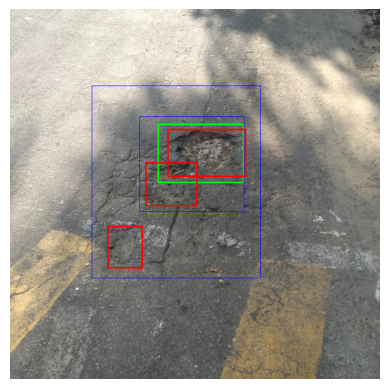

Average Validation Accuracy: 94.8%
Average Precision (AP): 0.0000


In [39]:
visualize_nms_boxes(model, test_loader, device)